# The bayesian bootstrap

Good uncertainty estimates are vital for decision-making. Being able to tell what your model does not know may be as valuable as getting everything else right, especially when your algortithm drives decisions that put a lot of resources at stake and few historical datapoints are available. 

However, doing that is not easy. The entire field of bayesian inference research dedicated itself to doing that, spinning off some more directed efforts to more complicated (and useful) models such as neural networks ([Osband et. al, 2018](https://papers.nips.cc/paper/8080-randomized-prior-functions-for-deep-reinforcement-learning.pdf), [Blundell et. al, 2015](https://arxiv.org/abs/1505.05424)) and random forests ([Ge et. al, 2019](https://arxiv.org/abs/1906.05440)). These efforts are one of the coolest things in ML right now, but sometimes, for data scientists in industry, it is not practical to use them.

On the other hand, the procedure of repeatedly drawing samples with replacement and performing whatever you want to do in these samples (training a model, calculating some statistic), a frequentist resampling method called **bootstrap**, is fairly practical, and has been shown to actually be a good approximation for bayesian posteriors ([Elements of Statistical Learning, p. 271](https://web.stanford.edu/~hastie/ElemStatLearn/), [Dimakopoulou et. al, 2018](https://arxiv.org/pdf/1711.07077.pdf), [Efron, 2013](https://arxiv.org/pdf/1301.2936.pdf)). When I want a quick, painless and non-parametric uncertainty estimate, the bootstrap fits like a glove. But I always questioned myself: "why is that?" and "how to make it even better?".

In this post, I'll try to dissect the bootstrap procedure from first principles and show you how to perform a simple hack on it to make it even better and (gasp!) bayesian.

# Why is this relevant?

 Having principled uncertainty estimates is paramount for decision making. However, I feel that many data scientists ignore them, mainly due to the pain it is to extract these estimates from more complicated models (neural nets, RFs, etc). I want to make the case for the bootstrap as a painless solution to this problem, and give you a better kind of bootstrap, the **bayesian bootstrap**, for you to use on your work.

In [0]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import dirichlet, norm, multinomial, gamma
from copy import deepcopy
from sklearn.utils import resample

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

In [0]:
# class for exact gaussian inference
class ExactGaussianInference:
    
    # initializing with prior paramters
    def __init__(self, prior_mu, prior_sigma, likelihood_sigma):
        
        # storing
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        self.post_mu = prior_mu
        self.post_sigma = prior_sigma
        self.likelihood_sigma = likelihood_sigma
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:
        
            # calculating needed statistics for the observations
            obs_mu = np.mean(obs)
            obs_sum = np.sum(obs)
            obs_n = len(obs)

            # updating posterior mean
            self.post_mu = (1/(1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2) *
                            (self.prior_mu/self.prior_sigma**2 + obs_sum/self.likelihood_sigma**2))

            # updating posterior sigma
            self.post_sigma = (1/self.prior_sigma**2 + obs_n/self.likelihood_sigma**2)**(-1)
            
        # return posterior
        return norm(self.post_mu, np.sqrt(self.post_sigma))

# class for exact gaussian inference
class BootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:

          # running bootstrap samples
          boots_samples = np.array([resample(obs) for _ in range(self.n_draws)])
          posterior_draws = boots_samples.mean(axis=1)

          # return posterior density via samples
          return posterior_draws

        else:
          print('Cannot run with no observations!')
          raise

# class for exact gaussian inference
class BayesianBootstrapPosteriorInference:
    
    # initializing with prior paramters
    def __init__(self, n_draws):
        
        # storing
        self.n_draws = n_draws
                
    # fitting the posterior for the mean
    def get_posterior(self, obs):
        
        # checking if there is any observation before proceeding
        if len(obs) > 0:

          # running bootstrap samples
          dir_samples = dirichlet([1] * len(obs)).rvs(self.n_draws)
          posterior_draws = (dir_samples * obs).sum(axis=1)

          # return posterior density via samples
          return posterior_draws

        else:
          print('Cannot run with no observations!')
          raise

## The result we will achieve

Suppose that you want to infer the (posterior) distribution over the mean of these datapoints: `[1.865, 3.053, 1.401, 0.569, 4.132]`. A quick and painless way to do that is just performing a lot of bootstrap samples and calculating the mean over and over again:

In [0]:
test_sample = np.array([1.865, 3.053, 1.401, 0.569, 4.132])
boots_samples = [resample(test_sample).mean() for _ in range(100000)]

Which will get you the following result:

Text(0.5, 1.0, 'Regular Bootstrap')

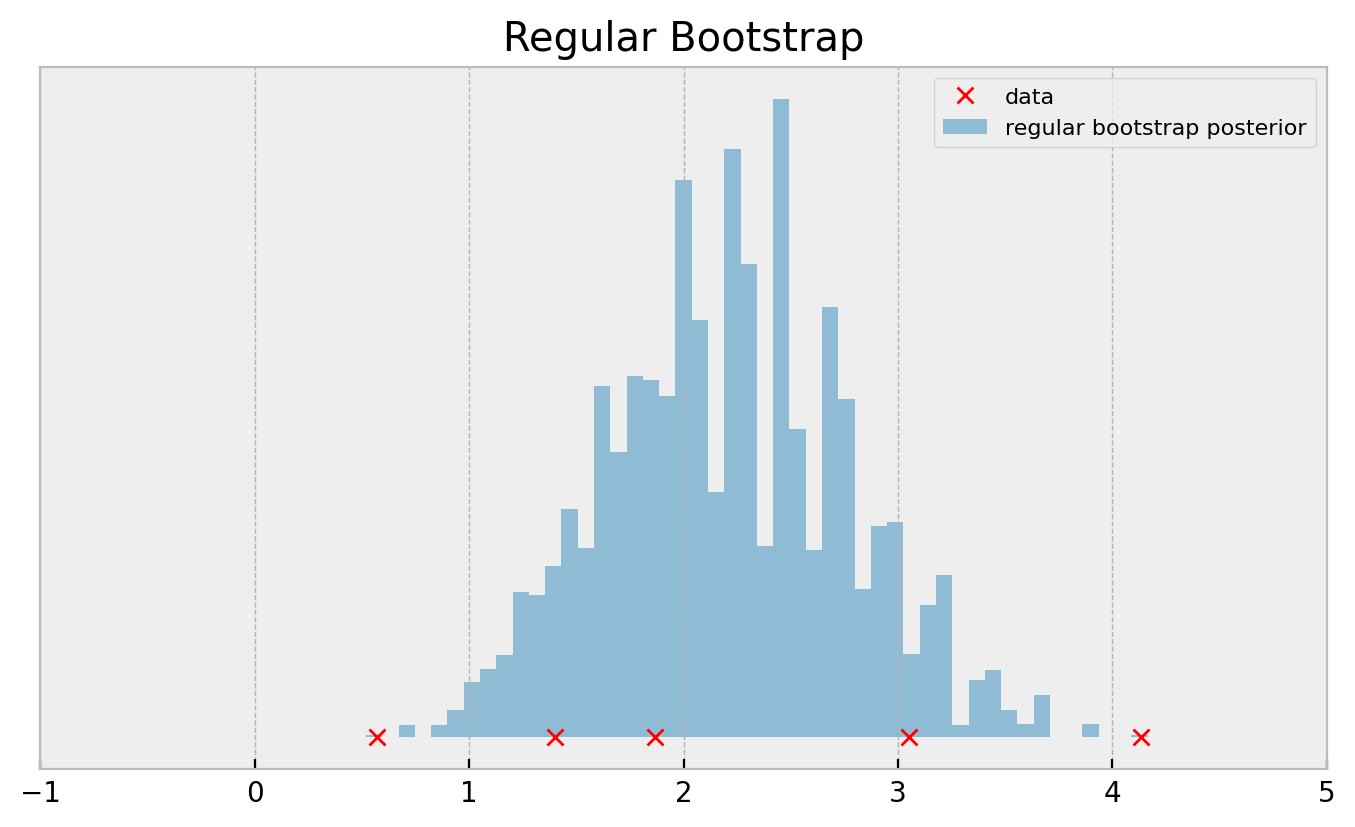

In [0]:
# opening figure
plt.figure(figsize=[7,4], dpi=100)
h = plt.hist(boots_samples, alpha=0.5, bins = np.linspace(-1, 5, 80), label='regular bootstrap posterior', density=True)
plt.plot(test_sample, [0]*test_sample.shape[0], 'rx', label='data')
plt.tight_layout()
plt.legend(fontsize=8)
plt.xlim(-1, 5)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Regular Bootstrap')

Even with 100000 bootstrap samples, the histogram doesn't get smooth. Apart from the fact that this result does not inspire confidence, this may deteriorate your application performance, especially if you're running a complicated multi-armed bandit and are using bootstrap as your posterior approximation.

There's a simple hack to make the bootstrap smoother though. Don't panic if you don't understand what is going on below, I'll show you the intuition later on the post:

In [0]:
test_sample = np.array([1.865, 3.053, 1.401, 0.569, 4.132])
dirichlet_samples = dirichlet([1] * len(test_sample)).rvs(100000)
bayes_boots_samples = (test_sample * dirichlet_samples).sum(axis=1)

This is called the **bayesian bootstrap** and outputs a much smoother posterior:

Text(0.5, 1.0, 'Bayesian Bootstrap')

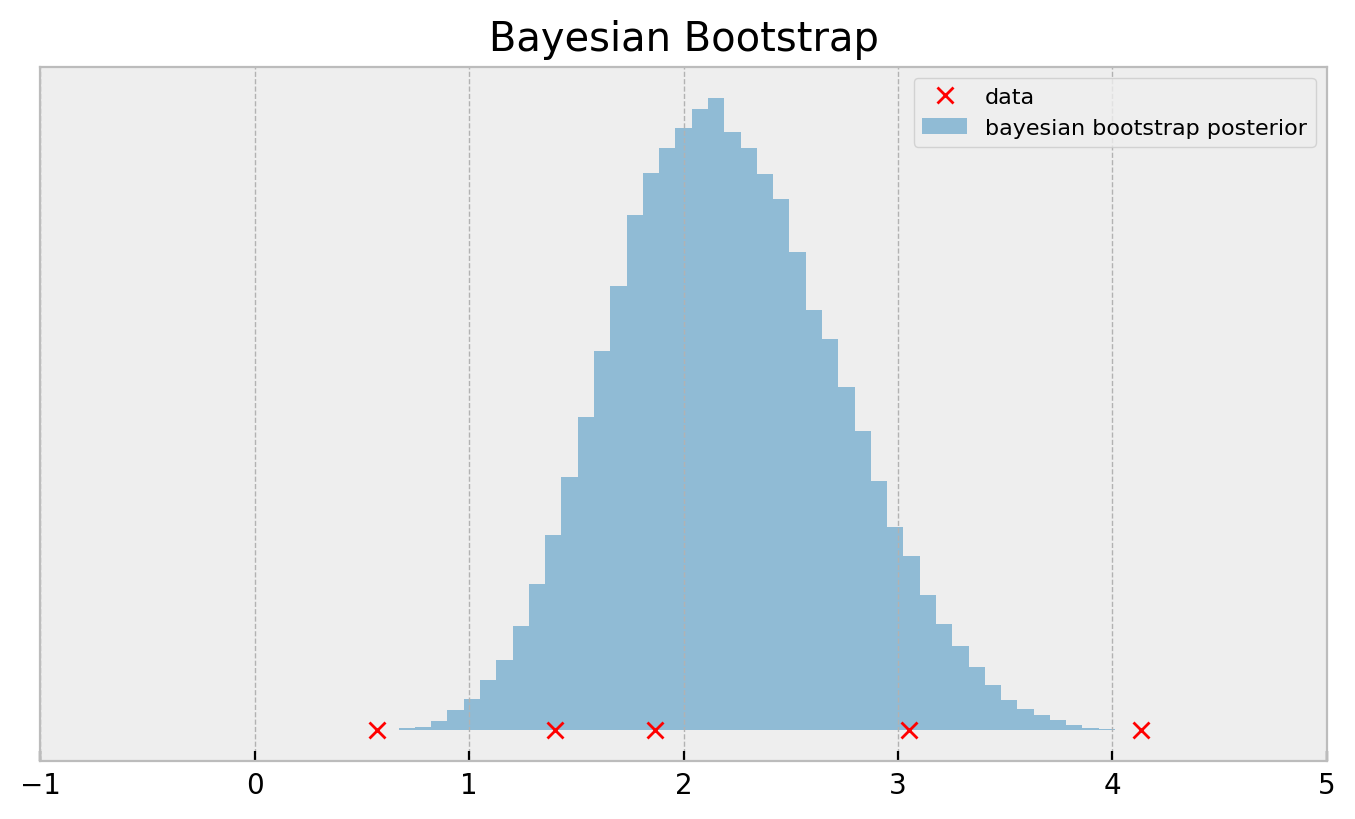

In [0]:
# opening figure
plt.figure(figsize=[7,4], dpi=100)
h = plt.hist(bayes_boots_samples, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bayesian bootstrap posterior', density=True)
plt.plot(test_sample, [0]*test_sample.shape[0], 'rx', label='data')
plt.tight_layout()
plt.legend(fontsize=8)
plt.xlim(-1, 5)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Bayesian Bootstrap')

If you need a more direct comparison:

Text(0.5, 1.0, 'Method Comparison')

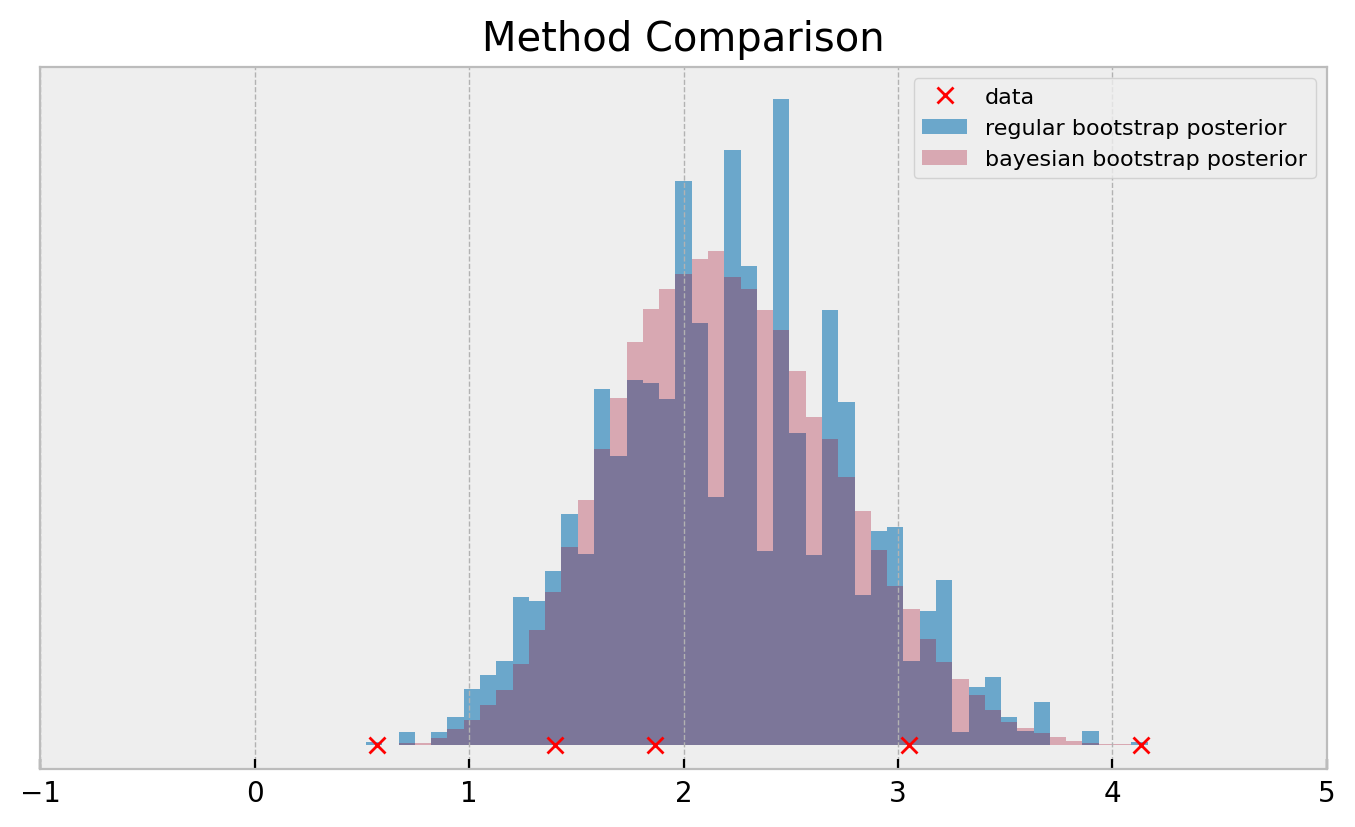

In [0]:
# opening figure
plt.figure(figsize=[7,4], dpi=100)
plt.hist(boots_samples, alpha=0.7, bins = np.linspace(-1, 5, 80), label='regular bootstrap posterior', density=True)
h = plt.hist(bayes_boots_samples, alpha=0.3, bins = np.linspace(-1, 5, 80), label='bayesian bootstrap posterior', density=True)
plt.plot(test_sample, [0]*test_sample.shape[0], 'rx', label='data')
plt.tight_layout()
plt.legend(fontsize=8)
plt.xlim(-1, 5)
plt.ylim(bottom=-0.05*h[0].max())
plt.yticks([])
plt.title('Method Comparison')

Both methods use exactly the same data. So how the bayesian bootstrap can produce much smoother posteriors? Let us find out!

## Bootstrap from first principles: posterior mean of Gaussian distribution

We start with a simple example so we can build from first principles: the classic problem of estimating the posterior distribution over the mean of a Gaussian.

We configure our distribution as $N(2, 1)$ and generate incresingly larger sets of datapoints: 

In [0]:
np.random.seed(100)
sample_9 = np.random.normal(2, 1, size=9)
sample_7 = deepcopy(sample_9[:7])
sample_5 = deepcopy(sample_9[:5])
sample_3 = deepcopy(sample_9[:3])

sample_list = [sample_3, sample_5, sample_7, sample_9]

A good property of this problem is that when we assume a Gaussian prior we have an analytical solution to it, since the posterior of a Gaussian prior given a Gaussian likelihood is also Gaussian (take a look [here](https://en.wikipedia.org/wiki/Conjugate_prior) if you don't believe me). So, we can compare our boostrap procedure to a reliable ground truth.

We devise classes `ExactGaussianInference` and `BootstrapPosteriorInference` ([link to code]()) and show the result below:

In [0]:
# configuring exact posterior
egi = ExactGaussianInference(0, 100, 1)

# calculating posteriors
exact_post_list = []
for sample in sample_list:
  exact_post_list.append(egi.get_posterior(sample))

In [0]:
# configuring bootstrap posterior
bpi = BootstrapPosteriorInference(10000)

# calculating posteriors
boots_post_list = []
for sample in sample_list:
  boots_post_list.append(bpi.get_posterior(sample))

In [0]:
def plot_fig_1():

  for i in range(4):

    post = exact_post_list[i]
    sample = sample_list[i]

    plt.subplot(2, 4, i+1)
    plt.fill_between(x_grid, post.pdf(x_grid), alpha=0.5, label='exact\nposterior')
    plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*post.pdf(x_grid).max())
    plt.yticks([])
    plt.title(f'Exact, N = {sample.shape[0]}')

  for i in range(4):

    post = boots_post_list[i]
    sample = sample_list[i]

    plt.subplot(2, 4, i+5)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Classic Bootstrap, N = {sample.shape[0]}')

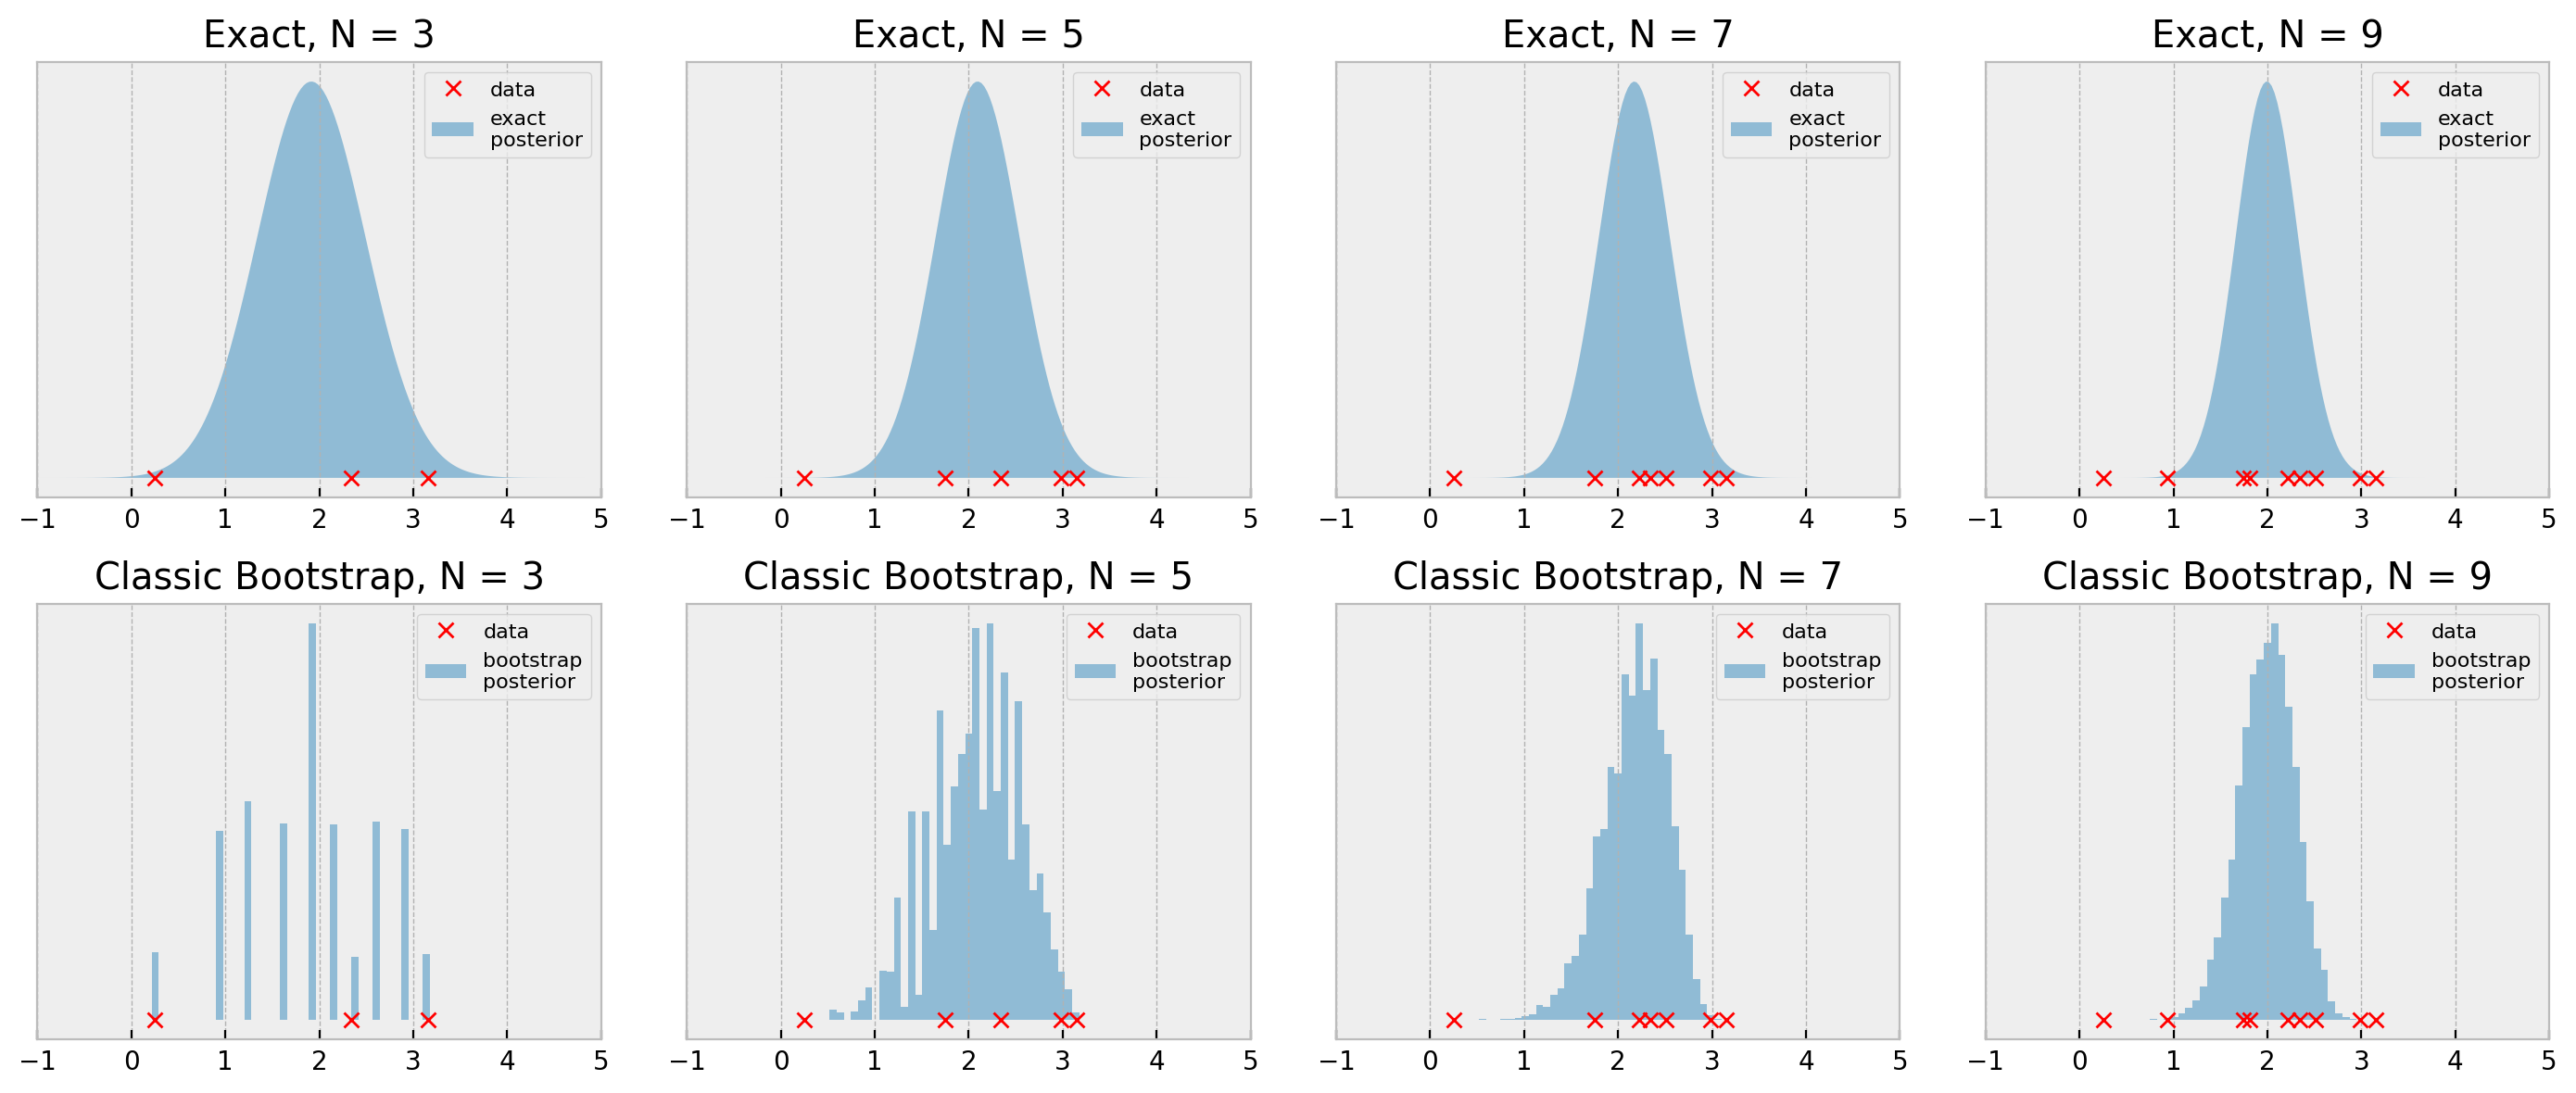

In [0]:
# grid for plotting pdf
x_grid = np.linspace(-1, 5, 200)

# opening figure
plt.figure(figsize=[14,6], dpi=100)

# plotting
plot_fig_1()

The bootstrap results look pretty reasonable when we consider the simplicity of the procedure, with `N=7` and `N=9` being very close to the true posterior. With `N=3` and `N=5`, the general shape of the posterior is ok, but it lacks smoothness, as we've seen before.

Can that be improved? Let us rewrite the bootstrap procedure to see.



### Rewriting the bootstrap as a (multinomial) weighted sum of samples

Let us now think about the bootstrap procedure in a different way. For clarity, let us use the array `[1,2,3]`. 

It is easy to draw bootstrap samples from it:

In [0]:
array = [1,2,3]
for _ in range(5):
  resampled_array = resample(array)
  print(f'Resampled array: {sorted(resampled_array)}, bootstrap average: {np.mean(resampled_array):.2f}')

Resampled array: [1, 1, 2], bootstrap average: 1.33
Resampled array: [2, 3, 3], bootstrap average: 2.67
Resampled array: [1, 1, 3], bootstrap average: 1.67
Resampled array: [2, 3, 3], bootstrap average: 2.67
Resampled array: [1, 2, 3], bootstrap average: 2.00


Now, let us build a different representation for these arrays, such that each entry represents the number of times that it was chosen by the procedure. Let us call it the "assignment counts" of the bootstrap. The original sample `[1,2,3]` is be represented by assignment counts `[1,1,1]` whereas a bootstrap sample that only selects the first element `[1,1,1]` is represented as `[3,0,0]`, for instance.

In [0]:
array = [1,2,3]
for _ in range(5):
  resampled_array = resample(array)
  count_array = [(np.array(resampled_array) == k).sum() for k in sorted(array)]
  print(f'Resampled array: {sorted(resampled_array)}, assignment counts: {count_array}, bootstrap average: {np.mean(resampled_array):.2f}')

Resampled array: [1, 2, 2], assignment counts: [1, 2, 0], bootstrap average: 1.67
Resampled array: [1, 2, 3], assignment counts: [1, 1, 1], bootstrap average: 2.00
Resampled array: [2, 2, 2], assignment counts: [0, 3, 0], bootstrap average: 2.00
Resampled array: [1, 1, 2], assignment counts: [2, 1, 0], bootstrap average: 1.33
Resampled array: [1, 2, 3], assignment counts: [1, 1, 1], bootstrap average: 2.00


These assignment count arrays look familiar... Draws from a multinomial distribution with size `N` and `1/N` probability for all entries perhaps?

In [0]:
n = len(array)
mult_samples = multinomial(n, [1./n] * n).rvs(5)
print(f'multinomial samples:\n{mult_samples}')

multinomial samples:
[[0 1 2]
 [2 1 0]
 [2 0 1]
 [2 1 0]
 [0 1 2]]


So, for instance, maybe we can calculate the bootstrap average as a weighted sum of samples, where the weights are draws from a multinomial distribution:

In [0]:
n = len(array)
mult_samples = multinomial(n, [1./n] * n).rvs(5)
boots_avg = ( mult_samples * np.array(array) ).sum(axis=1) * 1/n
print(f'multinomial samples:\n{mult_samples},\nbootstrap average:\n{boots_avg.reshape(-1,1)}')

multinomial samples:
[[0 3 0]
 [3 0 0]
 [1 0 2]
 [2 1 0]
 [1 1 1]],
bootstrap average:
[[2.        ]
 [1.        ]
 [2.33333333]
 [1.33333333]
 [2.        ]]


Cool, huh? We came up with a vectorized implementation of the bootstrap procedure. However, we can improve it further. The multinomial distribution is discrete, and that is why we get the "non-smooth" pattern in the first place. If we normalize the weights, we can only get the values `0.`,`0.333`,`0.666` and `1.`.

In [0]:
mult_samples = multinomial(n, [1./n] * n).rvs(5) * 1/n
print(f'multinomial samples:\n{mult_samples}')

multinomial samples:
[[0.33333333 0.33333333 0.33333333]
 [0.66666667 0.         0.33333333]
 [0.         0.66666667 0.33333333]
 [0.33333333 0.         0.66666667]
 [0.33333333 0.33333333 0.33333333]]


Why should the weights be restricted to these proportions only? Actually, no reason at all! There is another distribution that can generate proportions in the interval 0-1, and is not confined to a finite set of values: the "uniform" dirichlet distribution:

In [0]:
dir_samples = dirichlet([1] * n).rvs(5)
print(f'dirichlet samples:\n{dir_samples}')

dirichlet samples:
[[0.27011012 0.14177025 0.58811963]
 [0.14524601 0.27300318 0.58175081]
 [0.32847744 0.46094557 0.21057699]
 [0.29518081 0.11706796 0.58775123]
 [0.0406882  0.50845487 0.45085693]]


The Dirichlet distribution, for this case, is parametrized with an N-dimensional array of 1's and outputs proportions that sum up to 1, like the normalized multinomial, but it is not restricted to a finite set of proportions, giving us a smoother distribution when we calculate boostrap averages:

In [0]:
n = len(array)
dir_samples = dirichlet([1] * n).rvs(5)
boots_avg = ( dir_samples * np.array(array) ).sum(axis=1)
print(f'dirichlet samples:\n{dir_samples},\nbootstrap average:\n{boots_avg.reshape(-1,1)}')

dirichlet samples:
[[0.33470063 0.30484561 0.36045376]
 [0.21050539 0.63889718 0.15059743]
 [0.54744278 0.10363572 0.3489215 ]
 [0.02188101 0.12377027 0.85434872]
 [0.10480257 0.53961196 0.35558547]],
bootstrap average:
[[2.02575312]
 [1.94009204]
 [1.80147872]
 [2.8324677 ]
 [2.2507829 ]]


This "smoother" way of doing the bootstrap is called the **bayesian bootstrap**. 

### Recap

So, let us recap:

1. The bootstrap procedure consists of repeatedly drawing samples with replacement and calculating our desired statistics in them
2. We can rewrite the bootstrap as a weighted sum, where the weights are drawn from a multinomial distribution with size `N` and `1/N` probability for all entries
3. We can convert the "classic" bootstrap to the bayesian bootstrap by exchanging the multinomial for a "uniform dirichlet", removing the "digital feel" the classic bootstrap has

## Bayesian Bootstrap in action

Let us now check our Gaussian posterior inference problem using bayesian bootstrarp as well.

In [0]:
# configuring bayesian bootstrap posterior
bbpi = BayesianBootstrapPosteriorInference(10000)

# calculating posteriors
bayesboots_post_list = []
for sample in sample_list:
  bayesboots_post_list.append(bbpi.get_posterior(sample))

In [0]:
def plot_fig_2():

  for i in range(4):

    post = exact_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+1)
    plt.fill_between(x_grid, post.pdf(x_grid), alpha=0.5, label='exact\nposterior')
    plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*post.pdf(x_grid).max())
    plt.yticks([])
    plt.title(f'Exact, N = {sample.shape[0]}')

  for i in range(4):

    post = boots_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+5)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Classic Bootstrap, N = {sample.shape[0]}')

  for i in range(4):

    post = bayesboots_post_list[i]
    sample = sample_list[i]

    plt.subplot(3, 4, i+9)
    h = plt.hist(post, alpha=0.5, bins = np.linspace(-1, 5, 80), label='bayesian\nbootstrap\nposterior', density=True)
    plt.plot(sample, [0]*sample.shape[0], 'rx', label='data')
    plt.tight_layout()
    plt.legend(fontsize=8)
    plt.xlim(-1, 5)
    plt.ylim(bottom=-0.05*h[0].max())
    plt.yticks([])
    plt.title(f'Bayesian Bootstrap, N = {sample.shape[0]}')

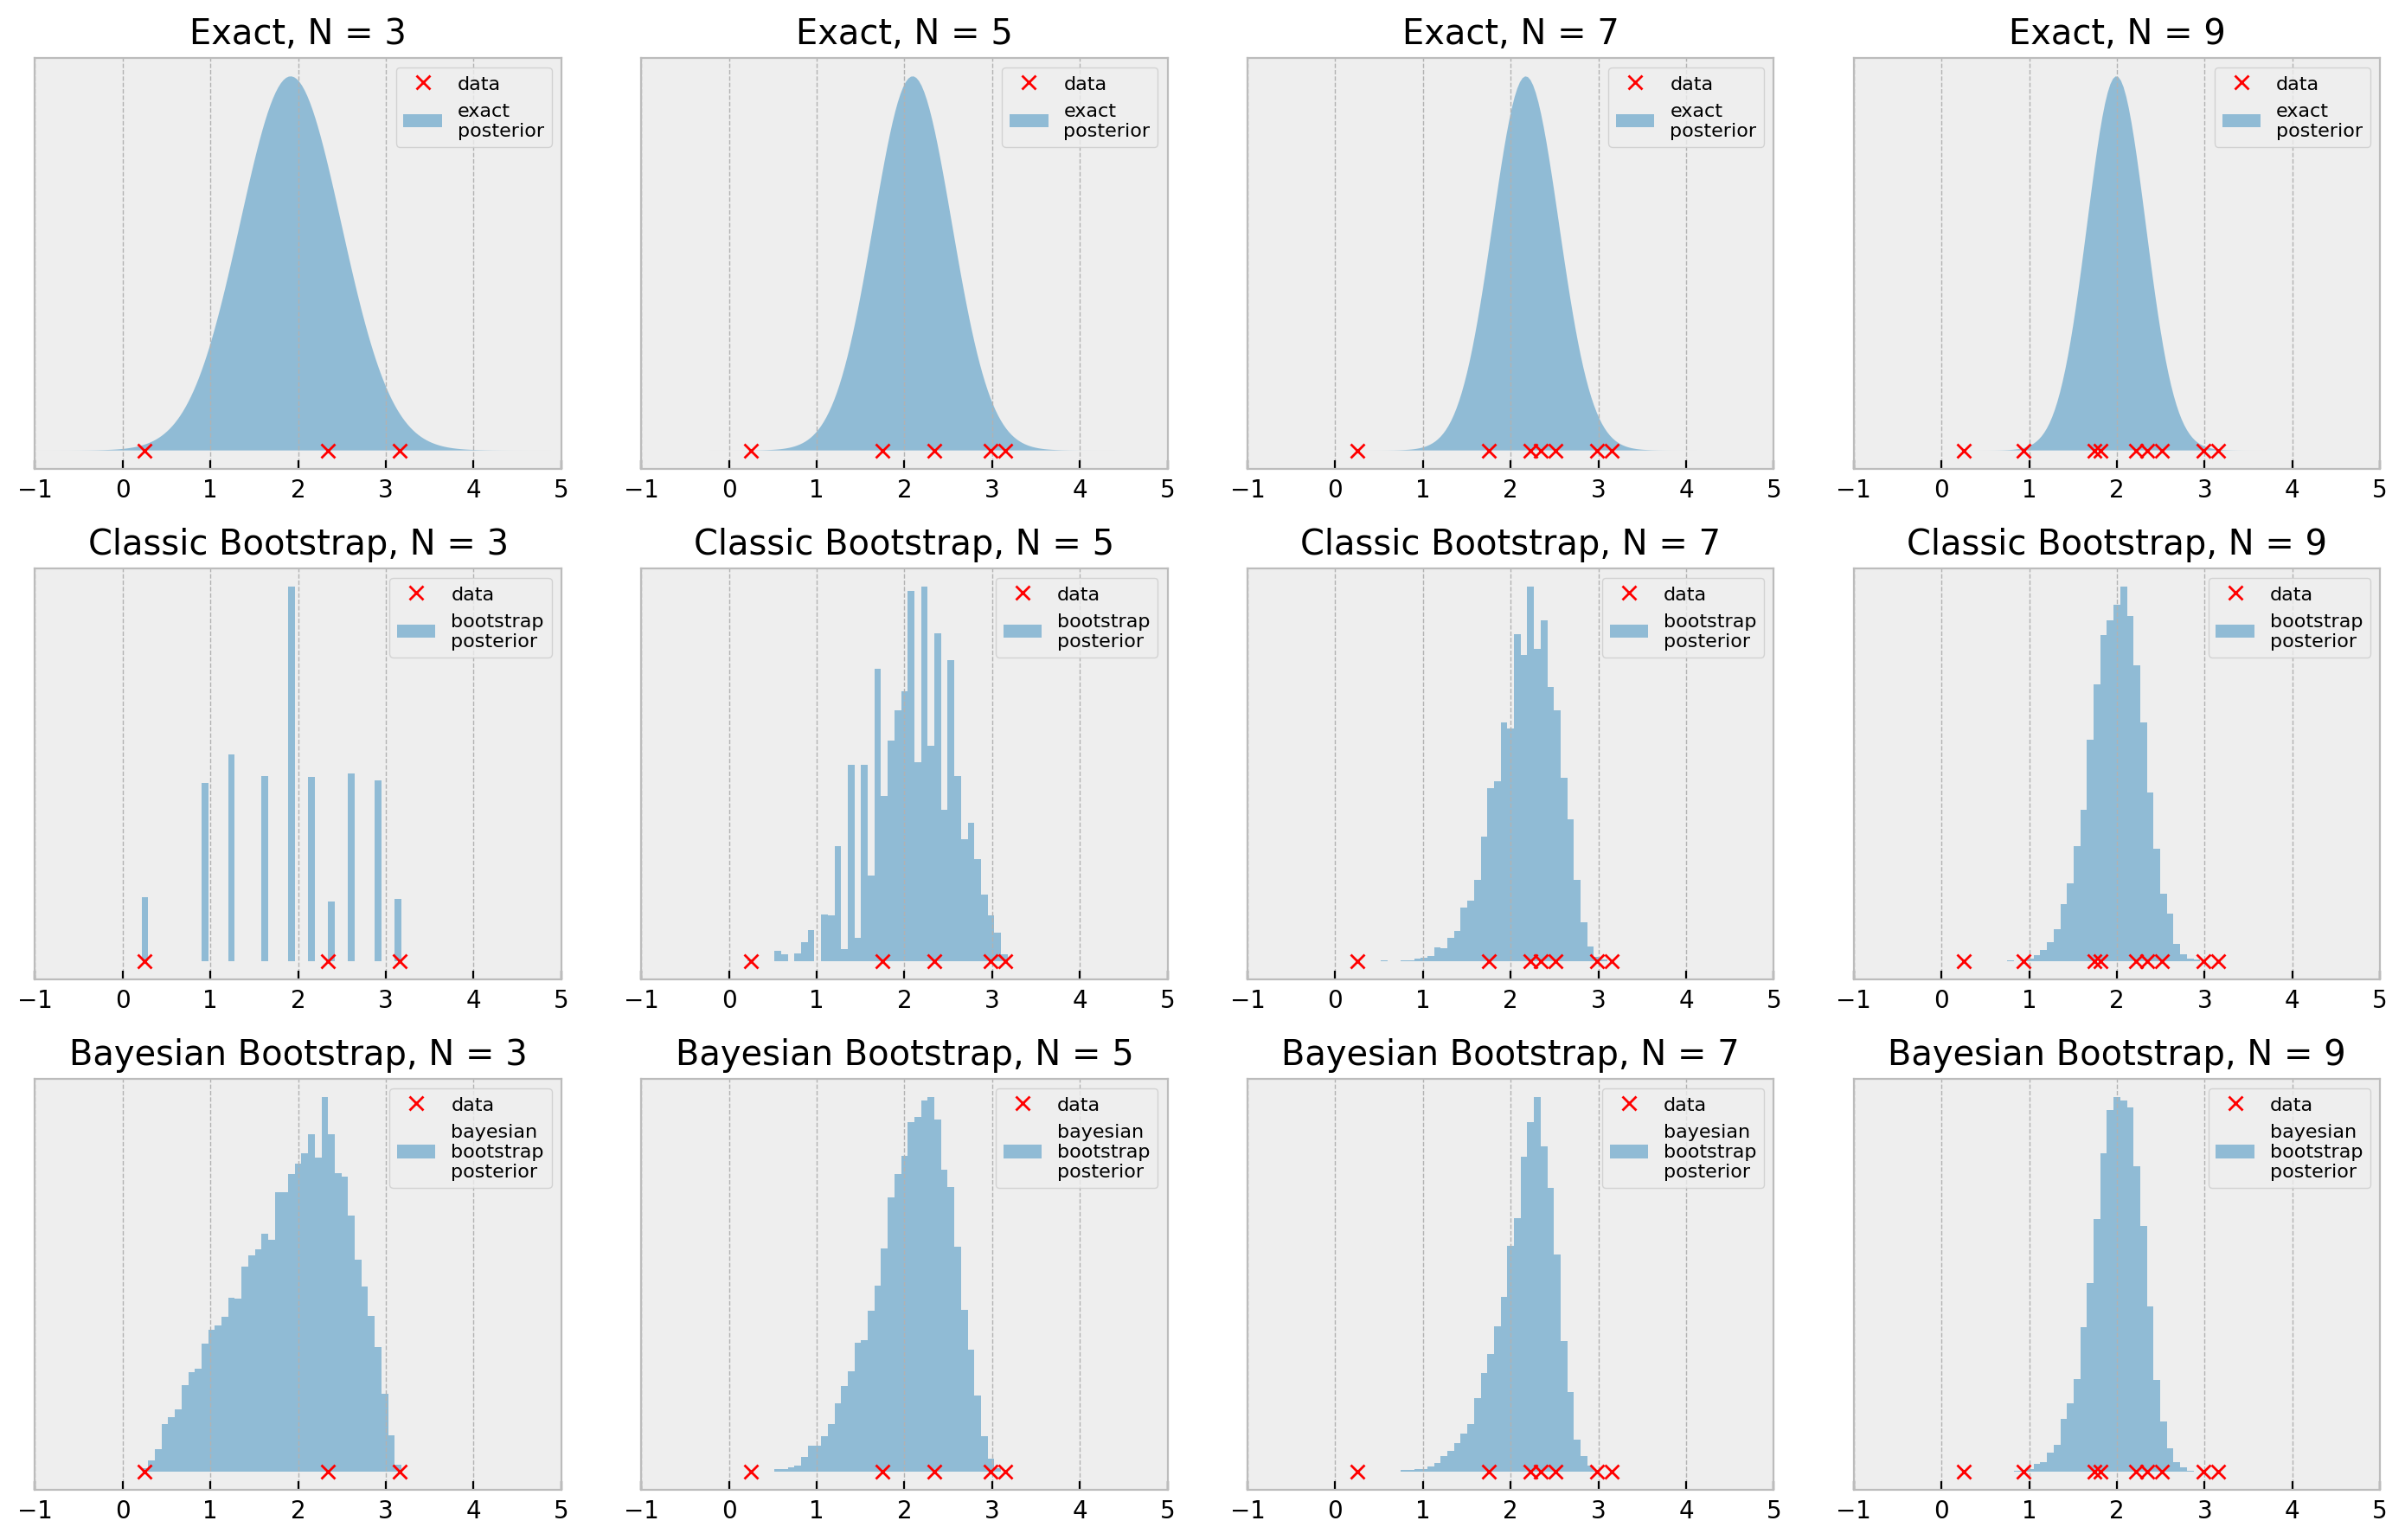

In [0]:
# grid for plotting pdf
x_grid = np.linspace(-1, 5, 200)

# opening figure
plt.figure(figsize=[14,9], dpi=100)

# plotting
plot_fig_2()

Cool! So we implemented the Bayesian Bootstrap: a faster (vectorized), smoother version of the bootstrap. I hope you use this in your future works! If you want to dig deeper, this [blog post](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/) by Rasmus Bååth gives a more in-depth view of the method.